# Lista 03

In [30]:
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import statsmodels.api as sm
from itertools import combinations

In [6]:
random.seed(42)

### Ex.02

Um experimento foi conduzido para estudar a eficiencia de um medicamento para tratar a hiperplasia prostática benigna. Em cada centro, pacientes foram atribuidos aleatoriamente em três grupos: controle, finasterida 1mg e finasterida 5mg. O conjunto de dados multicenter.csv ([disponível aqui](https://dataverse.harvard.edu/file.xhtml?fileId=7440246&version=4.0)) fornece, para cada centro, algumas estatísticas resumo para a pontuação dos sintomas (_Y_). Esta pontuação é a soma das respostas
a nove questões (0–4) sobre diversos sintomas. Os resultados das colunas são:

* **center**: ID dos centros,
* **n0**, **n1**, **n5**: tamanho da amostra em cada um dos grupos (controle, finasterida 1mg e finasterida 5mg).
* **mean0**, **mean1**, **mean5**: média dos resultados em cada um dos grupos (controle, finasterida 1mg e finasterida 5mg).
* **sd0**, **sd1**, **sd5**: desvio padrão dos resultados em cada um dos grupos (controle, finasterida 1mg e finasterida 5mg).

Estabeleça as hipóteses apropriadas e faça o teste correspondente, separadamente, para finasterida 1mg vs control e finasterida 5mg vs control. Considere cada centro como um estrato.


In [7]:
multicenter = pd.read_csv(r".\multicenter.csv", sep=r"\s+|;|:|,", engine="python")
print(f"Number of entries: {len(multicenter)}")
multicenter.head()

Number of entries: 29


,center,n0,mean0,sd0,n1,mean1,sd1,n5,mean5,sd5
0,1,7,0.43,4.58,7,-5.43,5.53,8,-2.63,3.38
1,2,11,0.10,4.21,11,-2.59,3.95,12,-2.21,4.14
2,3,6,2.58,4.80,6,-3.94,4.25,7,1.29,7.39
3,4,10,-2.30,3.86,10,-1.23,5.17,10,-1.40,2.27
4,5,10,2.08,6.46,10,-6.70,7.45,10,-5.13,3.91


<Axes: >

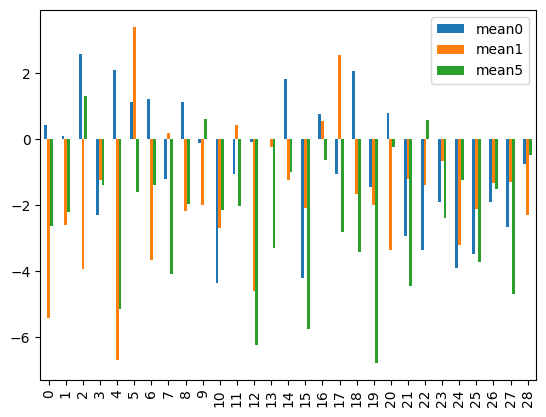

In [8]:
multicenter[["mean0", "mean1", "mean5"]].plot.bar()

In [9]:
def run_neyman_multicenter(n_k_1, y_k_1_mean, sd_k_1, n_k_0, y_k_0_mean, sd_k_0):
    n_k = [nk1 + nk0 for (nk1, nk0) in zip(n_k_1, n_k_0)]
    n = sum(n_k)
    pi_k = [nk / n for nk in n_k]

    tau_hat_k = [yk1 - yk0 for (yk1, yk0) in zip(y_k_1_mean, y_k_0_mean)]
    tau_hat_s = sum([pik * tau_k for (pik, tau_k) in zip(pi_k, tau_hat_k)])

    var_hat_k = [
        sdk1**2 / nk1 + sdk0**2 / nk0
        for (sdk1, nk1, sdk0, nk0) in zip(sd_k_1, n_k_1, sd_k_0, n_k_0)
    ]
    var_hat_s = sum([pik**2 * var_hat for (pik, var_hat) in zip(pi_k, var_hat_k)])

    interval_lower = tau_hat_s - norm.ppf(0.975) * np.sqrt(var_hat_s)
    interval_upper = tau_hat_s + norm.ppf(0.975) * np.sqrt(var_hat_s)

    t_s = tau_hat_s / np.sqrt(var_hat_s)
    print(f"  tau_hat_s: {tau_hat_s:.2f}")
    print(f"  var_hat_s^1/2: {np.sqrt(var_hat_s):.2f}")
    print(f"  95% confidence interval: [{interval_lower:0.2f},{interval_upper:0.2f}]")
    print(f"  p-value: {norm.cdf(t_s):.4f}")

In [10]:
# Results
print("finasterida 1mg")

run_neyman_multicenter(
    n_k_1=multicenter["n1"],
    y_k_1_mean=multicenter["mean1"],
    sd_k_1=multicenter["sd1"],
    n_k_0=multicenter["n0"],
    y_k_0_mean=multicenter["mean0"],
    sd_k_0=multicenter["sd0"],
)


print("finasterida 5mg")

run_neyman_multicenter(
    n_k_1=multicenter["n5"],
    y_k_1_mean=multicenter["mean5"],
    sd_k_1=multicenter["sd5"],
    n_k_0=multicenter["n0"],
    y_k_0_mean=multicenter["mean0"],
    sd_k_0=multicenter["sd0"],
)

finasterida 1mg
  tau_hat_s: -0.66
  var_hat_s^1/2: 0.41
  95% confidence interval: [-1.47,0.15]
  p-value: 0.0562
finasterida 5mg
  tau_hat_s: -1.64
  var_hat_s^1/2: 0.40
  95% confidence interval: [-2.43,-0.86]
  p-value: 0.0000


### Ex.03

Reanalize o dataset lalonde sob a perspective de Fisher e de Neyman.

* Considere **race** (**black**, **hisp**, **other**) como estrato.
* Considere **marital status** (**married**) como estrato.
* Considere o **high school diploma** (**nodegr**) como estrato.
* Discuta os resultados e compare com os obtidos sob CRE.

In [11]:
lalonde = pd.read_csv(r".\lalonde.csv", sep=r"\s+|;|:|,", engine="python")
print(f"Number of entries: {len(lalonde)}")
lalonde.head()

Number of entries: 445


,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [12]:
lalonde["race"] = np.where(
    lalonde["black"] == 1, 0, np.where(lalonde["hisp"] == 1, 1, 2)
)

In [13]:
def get_z_random(z, x):
    z_random = z.copy()
    for k in x.unique():
        z_k = z_random[x == k].sample(n=len(z_random[x == k]))
        z_random[x == k] = z_k.values
    return z_random


def get_tau_hat(y1, y0):
    return y1.sum() / len(y1) - y0.sum() / len(y0)


def get_tau_hat_s(y, z, x):
    tau_hat_s = 0
    for k in x.unique():
        pi_k = len(x[x == k]) / len(x)
        y_k = y[x == k]
        z_k = z[x == k]
        tau_hat_k = get_tau_hat(y_k[z_k == 1], y_k[z_k == 0])
        tau_hat_s += pi_k * tau_hat_k
    return tau_hat_s


def get_var_hat(y1, y0):
    s2_hat_1 = np.var(y1, ddof=1)
    s2_hat_0 = np.var(y0, ddof=1)
    return s2_hat_1 / len(y1) - s2_hat_0 / len(y0)


def get_var_hat_s(y, z, x):
    var_hat_s = 0
    for k in x.unique():
        pi_k = len(x[x == k]) / len(x)
        y_k = y[x == k]
        z_k = z[x == k]
        var_hat_k = get_var_hat(y_k[z_k == 1], y_k[z_k == 0])
        var_hat_s += pi_k**2 * var_hat_k
    return var_hat_s


def describe_classes(z, x):
    for k in x.unique():
        zk = z[x == k]
        print(
            f"   Class {k}: nk = {len(zk)},  nk1 = {len(zk[zk==1])},  nk0 = {len(zk[zk==0])}"
        )

In [14]:
def run_frt(y, z, x, mc=10000):
    tau_hat = get_tau_hat_s(y, z, x)
    tau_hat_list = []
    for _ in range(mc):
        z_random = get_z_random(z, x)
        tau_hat_list.append(get_tau_hat_s(y, z_random, x))
    p_value = sum([1 for t in tau_hat_list if abs(tau_hat) < abs(t)]) / mc
    print(f"   FRT: p-value = {p_value:0.4f}")

In [15]:
def run_ney(y, z, x, negative_effect=False):
    tau_hat = get_tau_hat_s(y, z, x)
    print(f"   tau_hat = {tau_hat:0.2f}")
    var_hat = get_var_hat_s(y, z, x)
    print(f"   var_hat^1/2 = {np.sqrt(var_hat):0.2f}")

    interval_lower = tau_hat - norm.ppf(0.975) * np.sqrt(var_hat)
    interval_upper = tau_hat + norm.ppf(0.975) * np.sqrt(var_hat)
    print(f"   95% confidence interval: [{interval_lower:0.2f},{interval_upper:0.2f}]")

    if negative_effect:
        p_value = 2 * norm.cdf(tau_hat / np.sqrt(var_hat))
    else:
        p_value = 2 * (1 - norm.cdf(tau_hat / np.sqrt(var_hat)))
    print(f"   NEY: p-value = {p_value:0.4f}")

In [16]:
y = lalonde["re78"]
z = lalonde["treat"]
x = {
    "No Stratification": pd.Series([0] * len(lalonde)),
    "By Race": lalonde["race"],
    "By Marital Status": lalonde["married"],
    "By High School Diploma": lalonde["nodegr"],
}

for k, x in x.items():
    print(k)
    describe_classes(z, x)
    run_frt(y, z, x, 10000)
    run_ney(y, z, x)

No Stratification
   Class 0: nk = 445,  nk1 = 185,  nk0 = 260


   FRT: p-value = 0.0035
   tau_hat = 1794.34
   var_hat^1/2 = 467.88
   95% confidence interval: [877.32,2711.37]
   NEY: p-value = 0.0001
By Race
   Class 0: nk = 371,  nk1 = 156,  nk0 = 215
   Class 1: nk = 39,  nk1 = 11,  nk0 = 28
   Class 2: nk = 35,  nk1 = 18,  nk0 = 17
   FRT: p-value = 0.0041
   tau_hat = 1794.97
   var_hat^1/2 = 479.80
   95% confidence interval: [854.59,2735.35]
   NEY: p-value = 0.0002
By Marital Status
   Class 1: nk = 75,  nk1 = 35,  nk0 = 40
   Class 0: nk = 370,  nk1 = 150,  nk0 = 220
   FRT: p-value = 0.0054
   tau_hat = 1767.18
   var_hat^1/2 = 467.83
   95% confidence interval: [850.25,2684.10]
   NEY: p-value = 0.0002
By High School Diploma
   Class 1: nk = 348,  nk1 = 131,  nk0 = 217
   Class 0: nk = 97,  nk1 = 54,  nk0 = 43
   FRT: p-value = 0.0096
   tau_hat = 1598.28
   var_hat^1/2 = 454.35
   95% confidence interval: [707.78,2488.79]
   NEY: p-value = 0.0004


### Ex.04

Assuma que randomizamos Z = (𝑍1, ⋯ , 𝑍𝑛) segundo um CRE e aceitamos este se e somente se 𝜙(Z, X) = 1 (em que 𝜙(⋅) é um criterio de balanceamento pre-estabelecido):

1. Mostre que se 𝑛1 = 𝑛0 e 𝜙(Z, X) = 𝜙(1𝑛 − Z, X) então $\hat{\tau{}}$ é não viesado para $\tau{}$.
1. Verifique que rerandomização utilizando a distância de Mahalanobis satisfaz 𝜙(Z, X) = 𝜙(1𝑛 − Z, X) se 𝑛1 = 𝑛0.
1. Dê um contraexemplo que ilustre que $\hat{\tau{}}$ é viesado para $\tau{}$ quando as condições acima não são satisfeitas

In [17]:
def get_all_combinations(n):
    combinations_list = [()]
    for i in range(1, n + 1):
        combinations_i = list(combinations(range(1, n + 1), i))
        combinations_list.extend(combinations_i)
    return combinations_list

In [18]:
y1 = pd.Series([1, 1, 0])
y0 = pd.Series([0, 0, 1])
x = pd.Series([0, 1, 2])

In [19]:
tau = y1.sum() / len(y1) - y0.sum() / len(y0)
print(f"tau = {tau}")

tau = 0.3333333333333333


In [20]:
def phi(x, z):
    x1 = x[z == 1]
    x0 = x[z == 0]
    if len(x1) * len(x0) == 0:
        return False
    return (x1.sum() / len(x1) - x0.sum() / len(x0)) == 0

In [21]:
tau_hat_s = []
for z in get_all_combinations(len(x)):
    zr = [0] * len(x)
    for i in z:
        zr[i - 1] = 1
    zr = pd.Series(zr)
    if phi(x, zr):
        y = y1.copy()
        y[zr == 0] = y0[zr == 0]
        # print(y)
        # print(x)
        x0 = pd.Series([0] * len(x))
        tau_hat_s.append(get_tau_hat_s(y, zr, x0))
print(np.mean(tau_hat_s))

0.5


### Ex.06

Reanalize o dataset Penn46_ascii.txt ([disponível aqui](https://dataverse.harvard.edu/file.xhtml?fileId=7440282&version=4.0)). O conjunto de dados já foi analisado na [aula 5](https://ctruciosm.github.io/MI628-unicamp/MI628_Aula04#/frt-sob-sre-aplicação) e consideramos treatment como indicador de tratamento (Z), log(_duration_) como resultado observado e quartes como variável estratificadora. Agora, queremos incluir todas as outras covariáveis na análise.

1. Realize ajustes por regressão dentro dos estratos do experimento e, em seguida, combine esses estimadores ajustados para estimar o efeito causal médio.
1. Reporte o estimador pontual, o erro padrão estimado e o intervalo de confiança de 95%.
1. Compare os resultados obtidos com aqueles sem ajuste por regressão.


[Colunas](http://www.econ.uiuc.edu/~roger/research/inference/khmal6.pdf):

* Indicator for the treatment group.
* Indicators for female, black and hispanic respondents.
* Number of dependents, with 2 indicating two or more dependents.
* Indicators for the 5 quarters of entry to the experiment.
* Indicator for whether the claimant _expected_ to be recalled" to a previous job.
* Indicators for whether the respondent was _young_ (less than 35), or _old_ (indicating age greater than 54).
* Indicator for whether claimant was employed in the durable goods industry.
* Indicator for whether the claimant was registered in one of the low unemployment short unemployment duration districts: Coatesville, Reading, or Lancaster.

In [22]:
penn = pd.read_csv(r".\Penn46_ascii.txt", sep=r"\s+|;|:|,", engine="python")
print(f"Number of entries: {len(penn)}")
penn.reset_index(inplace=True)
penn.head()

Number of entries: 6384


,index,duration,treatment,female,black,hispanic,ndependents,recall,young,old,quarter,durable,lusd
0,1,18.011343,0,0,0,0,2,0,0,0,5,0,0
1,4,1.003399,0,0,0,0,0,0,0,0,5,0,1
2,5,26.960396,0,0,0,0,0,0,0,0,4,0,1
3,6,7.009044,1,0,0,0,0,0,0,0,2,0,0
4,12,9.022409,1,0,0,0,0,0,1,0,3,0,0


In [23]:
penn["y"] = np.log(penn["duration"])

y = penn["y"]
z = penn["treatment"]
x = penn["quarter"]
xi_ = [
    "female",
    "black",
    "hispanic",
    "ndependents",
    "recall",
    "young",
    "old",
    "durable",
    "lusd",
]
all_columns = ["treatment"] + xi_

In [24]:
print("No Regression + No Block")
run_ney(y, z, pd.Series([0] * len(x)), negative_effect=True)

No Regression + No Block
   tau_hat = -0.08
   var_hat^1/2 = 0.01
   95% confidence interval: [-0.09,-0.07]
   NEY: p-value = 0.0000


In [25]:
print("No Regression + Block")
run_ney(y, z, x, negative_effect=True)

No Regression + Block
   tau_hat = -0.09
   var_hat^1/2 = 0.01
   95% confidence interval: [-0.11,-0.07]
   NEY: p-value = 0.0000


In [26]:
def do_regression(y, X, negative_effect=False, verbose=False, summary=False):
    X_norm = X.copy()
    z_name = X_norm.columns[0]
    x_names = X_norm.columns[1:]
    X_norm[x_names] -= X[x_names].mean()

    for xi in x_names:
        X_norm[f"z:{xi}"] = X_norm[xi] * X_norm[z_name]

    model = sm.OLS(y, sm.add_constant((X_norm)))
    results = model.fit()

    tau_hat = results.params[z_name]
    robust_se_ehw = results.get_robustcov_results().bse
    var_hat = robust_se_ehw[1] * robust_se_ehw[1]

    if verbose:
        print(f"   tau_hat = {tau_hat:0.4f}")
        print(f"   var_hat^1/2 = {np.sqrt(var_hat):0.4f}")
        interval_lower = tau_hat - norm.ppf(0.975) * np.sqrt(var_hat)
        interval_upper = tau_hat + norm.ppf(0.975) * np.sqrt(var_hat)
        print(
            f"   95% confidence interval: [{interval_lower:0.4f},{interval_upper:0.4f}]"
        )
        if negative_effect:
            p_value = 2 * norm.cdf(tau_hat / np.sqrt(var_hat))
        else:
            p_value = 2 * (1 - norm.cdf(tau_hat / np.sqrt(var_hat)))
        print(f"   NEY: p-value = {p_value:0.4f}")

    if summary:
        print(results.summary())
    return tau_hat, var_hat

In [27]:
print("Regression + No Block")
_ = do_regression(
    y=penn["y"], X=penn[all_columns], negative_effect=True, verbose=True, summary=True
)

Regression + No Block


   tau_hat = -0.0822
   var_hat^1/2 = 0.0297
   95% confidence interval: [-0.1405,-0.0240]
   NEY: p-value = 0.0057
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     14.24
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           2.44e-45
Time:                        09:26:00   Log-Likelihood:                -10137.
No. Observations:                6384   AIC:                         2.031e+04
Df Residuals:                    6364   BIC:                         2.045e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------

In [28]:
pi_x = []
tau_hat_x = []
var_hat_x = []

x = penn["quarter"]
k_ = x.unique()
k_.sort()
for k in k_:
    pi_k = len(x[x == k]) / len(x)
    print(f"Xi = {k} ({pi_k*100:0.2f}%)")
    df = penn[x == k]
    tau_hat_k, var_hat_k = do_regression(
        y=df["y"], X=df[all_columns], negative_effect=True, verbose=True, summary=False
    )

    pi_x.append(pi_k)
    tau_hat_x.append(tau_hat_k)
    var_hat_x.append(var_hat_k)

Xi = 0 (5.03%)
   tau_hat = 0.0310
   var_hat^1/2 = 0.1591
   95% confidence interval: [-0.2808,0.3428]
   NEY: p-value = 1.1544
Xi = 1 (1.39%)
   tau_hat = -0.0203
   var_hat^1/2 = 0.2677
   95% confidence interval: [-0.5451,0.5044]
   NEY: p-value = 0.9395
Xi = 2 (22.62%)
   tau_hat = -0.0924
   var_hat^1/2 = 0.0584
   95% confidence interval: [-0.2069,0.0221]
   NEY: p-value = 0.1136
Xi = 3 (26.00%)
   tau_hat = -0.1259
   var_hat^1/2 = 0.0572
   95% confidence interval: [-0.2380,-0.0137]
   NEY: p-value = 0.0278
Xi = 4 (24.26%)
   tau_hat = -0.1081
   var_hat^1/2 = 0.0609
   95% confidence interval: [-0.2275,0.0113]
   NEY: p-value = 0.0759
Xi = 5 (20.69%)
   tau_hat = -0.0365
   var_hat^1/2 = 0.0730
   95% confidence interval: [-0.1797,0.1066]
   NEY: p-value = 0.6170


In [29]:
print("With Regression + Block")

tau_hat_s = sum([pi * tau_hat for (pi, tau_hat) in zip(pi_x, tau_hat_x)])
var_hat_s = sum([pi**2 * var_hat for (pi, var_hat) in zip(pi_x, var_hat_x)])

print(f"   tau_hat = {tau_hat_s:0.4f}")
print(f"   var_hat^1/2 = {np.sqrt(var_hat_s):0.4f}")
interval_lower = tau_hat_s - norm.ppf(0.975) * np.sqrt(var_hat_s)
interval_upper = tau_hat_s + norm.ppf(0.975) * np.sqrt(var_hat_s)
print(f"   95% confidence interval: [{interval_lower:0.4f},{interval_upper:0.4f}]")
p_value = 2 * norm.cdf(tau_hat_s / np.sqrt(var_hat_s))
print(f"   NEY: p-value = {p_value:0.4f}")

With Regression + Block
   tau_hat = -0.0861
   var_hat^1/2 = 0.0303
   95% confidence interval: [-0.1456,-0.0267]
   NEY: p-value = 0.0045
